In [1]:
import sys
sys.path.append('../src')
import exlib

In [2]:
import torch
import torchvision
import torch.nn.functional as F
import shap
from transformers import AutoModelForImageClassification, AutoImageProcessor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
model_name = 'google/vit-base-patch16-224'
model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)
model = model.cuda()
model.eval()
X, y = shap.datasets.imagenet50()

X = torch.from_numpy(X).permute(0,3,1,2).float()[0:1]
X = torch.tensor(processor(X)['pixel_values'][0][None]).to(device)
X.shape

# y = torch.from_numpy(y).long()[0:2] #these labels are garbage

torch.Size([1, 3, 224, 224])

In [3]:
from collections import namedtuple
import torch.nn as nn

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs)
        return outputs.logits

In [4]:
from exlib.explainers.fullgrad import FullGradImageCls

In [5]:

wrapped_model = WrappedBackboneModelRaw(model).to(device)

In [6]:
explainer = FullGradImageCls(wrapped_model).to(device)

expln = explainer(X, torch.tensor([[0]]).to(device))

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


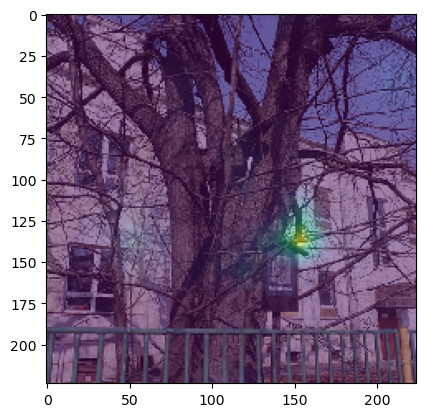

In [7]:
import matplotlib.pyplot as plt

plt.imshow(((X + 1)/2)[0].permute(1,2,0).detach().cpu())
plt.imshow(expln.attributions[0][0].detach().cpu(), alpha=0.5)